<a href="https://colab.research.google.com/github/erichsiao1106/cnn/blob/master/lymphoma_transferlearning_freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [ ]:
IMG_SIZE = 200
class_map = {'CLL':0, 'MCL': 1, 'FL': 2}

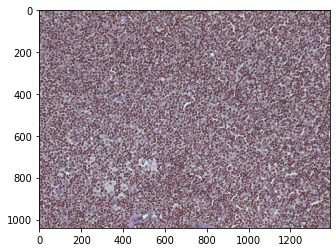

In [ ]:
# Read single image
data_path = 'drive/My Drive/class/勞動部/week8/lymphoma/*/*.tif' 
img_paths = glob(data_path)
# img_paths = np.random.choice(img_paths, 100) # demo for 200 images
img = cv2.imread(img_paths[0])
plt.imshow(img)

((1040, 1388, 3), (200, 200, 3))

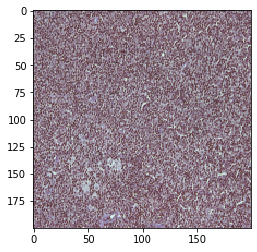

In [ ]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/class/勞動部/week8/lymphoma/CLL/sj-05-3874-R2_001.tif'

In [ ]:
cls = img_path.split('/')[-2]
cls

'CLL'

In [ ]:
class_map[cls]

0

In [ ]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [ ]:
for i, path in tqdm(enumerate(sorted(img_paths))):
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [ ]:
# label count
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 113, 1.0: 122, 2.0: 139}

In [ ]:
from keras.applications.inception_v3 import preprocess_input
X = preprocess_input(X)
y_onehot = keras.utils.to_categorical(y, num_classes=3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 200, 200, 3), (75, 200, 200, 3), (299, 3), (75, 3))

In [ ]:
# 1
base_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(base_model.input, predictions)

# freeze base model
for layer in base_model.layers:
    layer.trainable = False

















87916544/87910968 [==============================] - 8s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 99, 99, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 99, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)


In [ ]:

logs = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100,
                verbose=1,
                callbacks=[early_stopping, reduce_lr],     
                validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 299 samples, validate on 75 samples
Epoch 1/100
299/299 [==============================] - 11s 37ms/step - loss: 1.3982 - acc: 0.3679 - val_loss: 1.1048 - val_acc: 0.3867
Epoch 2/100
299/299 [==============================] - 1s 2ms/step - loss: 0.9703 - acc: 0.5117 - val_loss: 1.2513 - val_acc: 0.3600
Epoch 3/100
299/299 [==============================] - 1s 2ms/step - loss: 0.8004 - acc: 0.6622 - val_loss: 1.5782 - val_acc: 0.3600
Epoch 4/100
299/299 [==============================] - 1s 2ms/step - loss: 0.7787 - acc: 0.6622 - val_loss: 1.4344 - val_acc: 0.4000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
299/299 [==============================] - 1s 2ms/step - loss: 0.7054 - acc: 0.7023 - val_loss: 1.4293 - val_acc: 0.3200
Epoch 6/100
299/299 [==============================] - 1s 2ms/step - loss: 0.5641 - acc: 0.8027 - val_loss: 1.

In [ ]:
history = logs.history

Text(0.5, 1.0, 'acc')

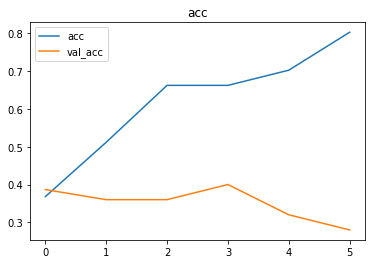

In [ ]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

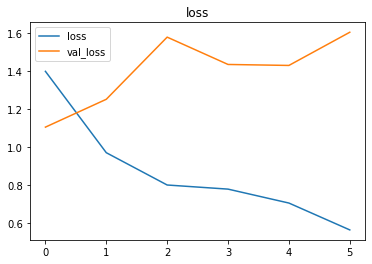

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(3)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))


(75,) (75,)
              precision    recall  f1-score   support

           0       0.27      0.68      0.39        19
           1       0.38      0.17      0.24        29
           2       0.36      0.19      0.24        27

    accuracy                           0.31        75
   macro avg       0.34      0.35      0.29        75
weighted avg       0.35      0.31      0.28        75

[[13  2  4]
 [19  5  5]
 [16  6  5]]
